In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Build the Dataset and Cross-reference Lists

## Read in the Dataset. 

Dataset was pulled from the facility's Process Historian using OsiSoft PI Datalink addon in Excel. The resulting values were then exported as .csv file.

Rarely is the data 'clean' enough where a column will get pulled in as anything but an object/string

In [2]:
# function to just sort out my personal dataset access shenanigans
def dataset_read(filename):
    url = 'https://raw.githubusercontent.com/nollijish/datasets/main/' + filename
    return pd.read_csv(url,
                       on_bad_lines='warn',
                       low_memory=False,
                       compression='gzip'
                       )

In [3]:
df = dataset_read('Cogen_CF_20221222-20100101.csv.gz')

## Setup Tags Lists

There are 3 generator units with individual 'tags' and then common fuel gas information tags and common weather tags.

Additionally, there are new tags and old tags. The old tags get shut off at some specific time and then the new tags get activated.

In [4]:
# setup for mapping tags between older tags and newer tags to create a more 
# complete dataset the formatting is for ease of interpretation
old_tags = [ # power output old tags
    ['1DW.PV','2DW.PV','3DW.PV']
    , # unit 1 old tags
    ['1CTDA1.PV','1CPD.PV','1AFPAP.PV','1TTXC.PV','90FGCOGEN1GTG']
    , # unit 2 old tags
    ['2CTDA1.PV','2CPD.PV','2AFPAP.PV','2TTXC.PV','90FGCOGEN2GTG']
    , # unit 3 old tags
    ['3CTDA1.PV','3CPD.PV','3AFPAP.PV','3TTXC.PV','90FGCOGEN3GTG']
]

new_tags = [ # power output new tags
    ['901DW.PV','902DW.PV','903DW.PV',]
    , # unit 1 new tags
    ['901CTDA1.PV','901CPD.PV','901AFPAP.PV','901TTXC.PV','90AQ137.FGCOGEN1GTG.PV']
    , # unit 2 new tags
    ['902CTDA1.PV','902CPD.PV','902AFPAP.PV','902TTXC.PV','90AQ237.FGCOGEN2GTG.PV']
    , # unit 3 new tags
    ['903CTDA1.PV','903CPD.PV','903AFPAP.PV','903TTXC.PV','90AQ337.FGCOGEN3GTG.PV']
]

# common tag identifiers for the unit tags once converted to MultiIndex
comm_tags = ['DW','CTDA1','CPD','AFPAP','TTXC','FG']

# explanatory and response variable tags
ac = ['TIMESTAMP'] + comm_tags

tags_dict = {}
for i in range(len(old_tags)):
    tags_dict.update(dict(zip(new_tags[i],old_tags[i])))

# Clean and Organize the Dataset

In [5]:
# make a flat list out of a list of lists
def flat(list__):
    return [item for sublist in list__ for item in sublist]

def munch_crunch_clean(df__):
    # search for all the strings in the process historian that contains bad data
    badpv = ['No Data','Bad Data','Bad','Intf Shut','Bad Input','I/O Timeout',
             'Configure','Scan Off','Out of Serv','Comm Fail','','Error',
             'Pt Created', 'Calc Failed','Invalid Float']
    # replace those strings with null values (which we can manage easier)
    df__ = df__.replace(to_replace=badpv,
                        value=np.nan,
                        inplace=False
                        )
    # search for empty strings using regex (not sure why above not working)
    df__ = df__.replace(r'^\s*$',np.nan,inplace=False,regex=True)
    
    # swap values over from old tags to new tags
    for i in new_tags:
        for k in i:
            mask_new = df__[k].isna()
            val = tags_dict[k]
            df__.loc[mask_new, k] = df__.loc[mask_new, val]
    # cut down to just the needed columns now that they have been combined
    df__ = df__.drop(columns=flat(old_tags))
    
    # create unit tags list and mapping to common tags for each of the models
    dfl = [[],[],[],[]]
    for i in range(1,4):
        unit_tags = ['TIMESTAMP'] + [new_tags[0][i-1]] + new_tags[i]
        map_dict = dict(zip(unit_tags,ac))
        dfl[i] = df__.loc[:,unit_tags].copy()
        dfl[i].rename(columns=map_dict,inplace=True)
        
    # concatenate back down to a single dataframe using multiindexing
    df__ = pd.concat([dfl[1], dfl[2], dfl[3]],
                     keys=['Unit1','Unit2','Unit3'],
                     names=['UNIT','CASE']
                     )
    
    # convert the TIMESTAMP to datetime format
    try:
        df__['TIMESTAMP'] = pd.to_datetime(arg=df__.loc[:,'TIMESTAMP'],
                                           errors='raise',
                                           format="%m/%d/%Y %H:%M"
                                           )
    except:
        df__['TIMESTAMP'] = pd.to_datetime(arg=df__.loc[:,'TIMESTAMP'],
                                           errors='coerce',
                                           format="%d-%b-%y %H:%M:%S"
                                           )
    # convert all sample values to float
    df__.loc[:,ac[1:]] = df__.loc[:,ac[1:]].astype(dtype=np.float64)
    
    return df__

In [6]:
df = munch_crunch_clean(df)

## Dataframe Columns Information
| Tag (Variable) | Variable Type | Data Type | Units | Description |
| :- | :- | :- | :- | :- |
| **General Data** |
| TIMESTAMP | Categorical Ordinal | datetime | Month/Day/Year Hour:Minutes | Time at observation |
| **Generator Data** |
| DW | Numerical Continuous | float | Megawatts (MW) | Generator Power Output |
| CTDA1 | Numerical Continuous | float | degrees Fahrenheit (°F) | Turbine Compressor Discharge Temperature |
| CPD | Numerical Continuous | float | pounds/inch$^2$ (psig) | Turbine Compressor Outlet Pressure |
| AFPAP | Numerical Continuous | float | inches of mercury (inHg) | Turbine Compressor Inlet Pressure |
| TTXC | Numerical Continuous | float | degrees Fahrenheit (°F) | Turbine Exhaust Temperature Average |
| FG | Numerical Continuous | float | thousand scuffs per hour (mscf/h) | Fuel Gas Burned |

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 341139 entries, ('Unit1', 0) to ('Unit3', 113712)
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   TIMESTAMP  341139 non-null  datetime64[ns]
 1   DW         336043 non-null  float64       
 2   CTDA1      339293 non-null  float64       
 3   CPD        334421 non-null  float64       
 4   AFPAP      338861 non-null  float64       
 5   TTXC       337522 non-null  float64       
 6   FG         296193 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 19.8+ MB


In [8]:
df.head()

TIMESTAMP         DW       CTDA1         CPD      AFPAP  \
UNIT  CASE                                                                     
Unit1 0    2010-01-01 00:00:00  40.906673  644.222656  161.566803  29.570610   
      1    2010-01-01 01:00:00  40.761490  645.698181  161.069000  29.539499   
      2    2010-01-01 02:00:00  40.811272  645.698181  161.566803  29.525236   
      3    2010-01-01 03:00:00  40.815418  645.609314  161.566803  29.538202   
      4    2010-01-01 04:00:00  40.661930  646.610840  161.027512  29.491720   

                   TTXC  FG  
UNIT  CASE                   
Unit1 0     1020.744019 NaN  
      1     1021.780518 NaN  
      2     1021.739014 NaN  
      3     1021.697510 NaN  
      4     1022.776489 NaN

## Create a fully clean dataset to build Distributions

In [9]:
df_nona = df.dropna()

In [10]:
df_nona.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 290322 entries, ('Unit1', 12225) to ('Unit3', 113712)
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   TIMESTAMP  290322 non-null  datetime64[ns]
 1   DW         290322 non-null  float64       
 2   CTDA1      290322 non-null  float64       
 3   CPD        290322 non-null  float64       
 4   AFPAP      290322 non-null  float64       
 5   TTXC       290322 non-null  float64       
 6   FG         290322 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 16.9+ MB


# Cluster into: Non-operational (NOP), Operational (OP)

In [12]:
# Use KMeans and hope that the clusters center around 0 and Operational values
clus = KMeans(n_clusters=2).fit(df_nona.loc[:,comm_tags])

PV	Clus1	Clus2
DW	39.52	0.30
CTDA1	648.67	52.22
CPD	161.63	-0.19
AFPAP	29.89	17.90
TTXC	987.84	59.94
FG	463.22	4.51



Text(0.5, 0.98, 'Process Variable Distributions')

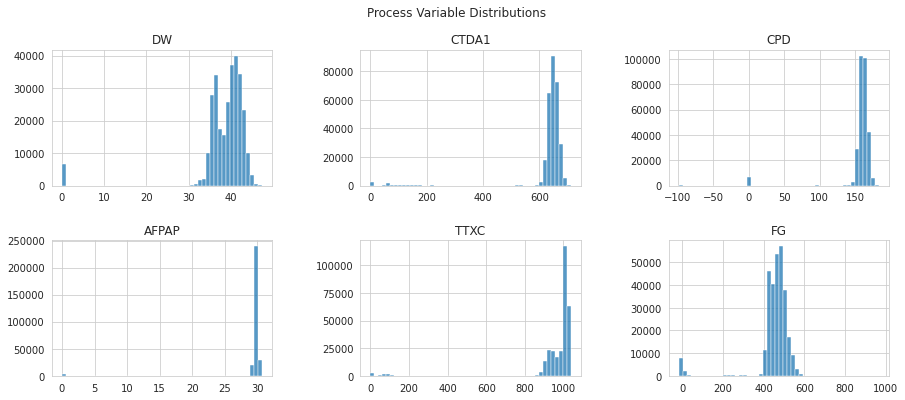

In [24]:
# Take a look at the cluster centers to ensure the values are where we expect
# Additionally, look at the distributions
out = 'PV\tClus0\tClus1'

sns.set_style('whitegrid')
fig, ax = plt.subplots(len(comm_tags), 2, figsize=(15, 6))

for i in range(len(comm_tags)):
    out += '\n{0}\t{1:0.2f}\t{2:0.2f}'.format(comm_tags[i],
                                            clus.cluster_centers_[0,i],
                                            clus.cluster_centers_[1,i]
                                            )
    sns.histplot(data=df_nona,
                 x=comm_tags[i],
                 bins=50,
                 ax=ax[i,0]
                 )
    ax[i,0].set(
        ylabel='',
        xlabel='',
        title=str(comm_tags[i]) + '@ cluster 1'
    )
out+='\n'
print(out)
fig.subplots_adjust(hspace=0.4,wspace=0.4)
fig.suptitle('Process Variable Distributions')